In [ ]:
%load_ext autoreload
%autoreload 2

To get scores...https://python.langchain.com/docs/how_to/add_scores_retriever/

# Test retiever score, standard

In [ ]:
import os
from aerospace_chatbot.services import DatabaseService, get_docs_questions_df
from aerospace_chatbot.processing import DocumentProcessor, QAModel
from aerospace_chatbot.services import EmbeddingService, LLMService

test_index={}
# test_index['db_type']='ChromaDB'
test_index['db_type']='Pinecone'
test_index['embedding_service']='OpenAI'
test_index['embedding_model']='text-embedding-3-large'
test_index['llm_service']='OpenAI'
test_index['llm_model']='gpt-4o'

# setup_fixture={}
# setup_fixture['chunk_method']='character_recursive'
# setup_fixture['chunk_size']=400
# setup_fixture['chunk_overlap']=0
# setup_fixture['batch_size']=50
test_prompt='What can you tell me about storage effects on hinge torque booms?'

index_name = 'text-embedding-3-large-mech-demo-2m'
rag_type = 'Standard'

# Load environment variables
from dotenv import load_dotenv
load_dotenv(override=True)
# Set LOCAL_DB_PATH environment variable
# os.environ['LOCAL_DB_PATH'] = os.path.abspath('.')

In [126]:
# Initialize services
embedding_service = EmbeddingService(
    model_service=test_index['embedding_service'],
    model=test_index['embedding_model']
)

llm_service = LLMService(
    model_service=test_index['llm_service'],
    model=test_index['llm_model'],
)

# Initialize database service
db_service = DatabaseService(
    db_type=test_index['db_type'],
    index_name=index_name,
    rag_type=rag_type,
    embedding_service=embedding_service,
    doc_type='document'
)

try:
    db_service.initialize_database()
except ValueError as e:
    print(f"Database initialization failed: {str(e)}")
    print(e)
    raise e


In [128]:
# Initialize QA model
qa_model = QAModel(
    db_service=db_service,
    llm_service=llm_service
)

# Run a query to create the query database
qa_model.query(test_prompt)

In [ ]:
qa_model.result[-1]['references']

In [ ]:
qa_model.sources[-1]

In [ ]:
qa_model.scores[-1]

# Test retriever score, parent-child

In [ ]:
import os
from aerospace_chatbot.services import DatabaseService, get_docs_questions_df
from aerospace_chatbot.processing import DocumentProcessor, QAModel
from aerospace_chatbot.services import EmbeddingService, LLMService

test_index={}
# test_index['db_type']='ChromaDB'
test_index['db_type']='Pinecone'
test_index['embedding_service']='OpenAI'
test_index['embedding_model']='text-embedding-3-large'
test_index['llm_service']='OpenAI'
test_index['llm_model']='gpt-4o'

# setup_fixture={}
# setup_fixture['chunk_method']='character_recursive'
# setup_fixture['chunk_size']=400
# setup_fixture['chunk_overlap']=0
# setup_fixture['batch_size']=50
test_prompt='What can you tell me about storage effects on hinge torque booms?'

index_name = 'text-embedding-3-large-test'
rag_type = 'Parent-Child'

# Load environment variables
from dotenv import load_dotenv
load_dotenv(override=True)
# Set LOCAL_DB_PATH environment variable
# os.environ['LOCAL_DB_PATH'] = os.path.abspath('.')

In [134]:
# Initialize services
embedding_service = EmbeddingService(
    model_service=test_index['embedding_service'],
    model=test_index['embedding_model']
)

llm_service = LLMService(
    model_service=test_index['llm_service'],
    model=test_index['llm_model'],
)

# Initialize database service
db_service = DatabaseService(
    db_type=test_index['db_type'],
    index_name=index_name,
    rag_type=rag_type,
    embedding_service=embedding_service,
    doc_type='document'
)

try:
    db_service.initialize_database()
except ValueError as e:
    print(f"Database initialization failed: {str(e)}")
    print(e)
    raise e

In [ ]:
# Initialize QA model
qa_model = QAModel(
    db_service=db_service,
    llm_service=llm_service
)

# Run a query to create the query database
qa_model.query(test_prompt)

In [ ]:
qa_model.result[-1]['references']

In [ ]:
qa_model.sources[-1]

In [ ]:
qa_model.scores[-1]

# Test partitioning update

In [1]:
from aerospace_chatbot.processing import DocumentProcessor
from aerospace_chatbot.services import EmbeddingService, LLMService, DatabaseService, prompts
from aerospace_chatbot.processing import QAModel
# from langchain_core.documents import Document

test_index={}
# test_index['db_type']='ChromaDB'
test_index['db_type']='Pinecone'
test_index['embedding_service']='OpenAI'
test_index['embedding_model']='text-embedding-3-large'
test_index['llm_service']='OpenAI'
test_index['llm_model']='gpt-4o'

# setup_fixture={}
# setup_fixture['chunk_method']='character_recursive'
chunk_size=400
chunk_overlap=0
batch_size=50

index_name = 'text-embedding-3-large-test'
rag_type = 'Standard'

# Load environment variables
from dotenv import load_dotenv
load_dotenv(override=True)
# Set LOCAL_DB_PATH environment variable
# os.environ['LOCAL_DB_PATH'] = os.path.abspath('.')

# Initialize logger
import logging
logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)

test_prompt='How does a thermal knife function in a cable based hold down release mechanism?'

In [2]:
# Initialize services
embedding_service = EmbeddingService(
    model_service=test_index['embedding_service'],
    model=test_index['embedding_model']
)

llm_service = LLMService(
    model_service=test_index['llm_service'],
    model=test_index['llm_model'],
)

doc_processor = DocumentProcessor(
    embedding_service=embedding_service,
    rag_type=rag_type,
    chunk_size=chunk_size,
    chunk_overlap=chunk_overlap,
)

# Initialize database service
db_service = DatabaseService(
    db_type=test_index['db_type'],
    index_name=index_name,
    rag_type=rag_type,
    embedding_service=embedding_service,
)

In [3]:
bucket_name = 'processing-pdfs'
docs = DocumentProcessor.list_bucket_pdfs(bucket_name)
docs

INFO:aerospace_chatbot.processing.documents:Number of PDFs found: 2
INFO:aerospace_chatbot.processing.documents:PDFs found: ['gs://processing-pdfs/1999_christiansen_reocr.pdf', 'gs://processing-pdfs/1999_cremers_reocr.pdf']


['gs://processing-pdfs/1999_christiansen_reocr.pdf',
 'gs://processing-pdfs/1999_cremers_reocr.pdf']

In [4]:
# partitioned_docs = doc_processor.load_and_partition_documents(docs,partition_by_api=False, upload_bucket=bucket_name)
# partitioned_docs

In [5]:
# chunk_obj, output_paths = doc_processor.chunk_documents(partitioned_docs)
# chunk_obj.chunk_convert(destination_type=Document)

In [6]:
try:
    db_service.initialize_database(clear=False)
except ValueError as e:
    print(f"Database initialization failed: {str(e)}")
    print(e)
    raise e

INFO:aerospace_chatbot.services.database:Validating index text-embedding-3-large-test and RAG type Standard
INFO:pinecone_plugin_interface.logging:Discovering subpackages in _NamespacePath(['/Users/danmueller/Documents/GitHub/aerospace_chatbot/.venv/lib/python3.11/site-packages/pinecone_plugins'])
INFO:pinecone_plugin_interface.logging:Looking for plugins in pinecone_plugins.inference
INFO:pinecone_plugin_interface.logging:Installing plugin inference into Pinecone
INFO:aerospace_chatbot.services.database:Pinecone index text-embedding-3-large-test found, not creating. Will be initialized with existing index.


In [7]:
# db_service.index_data(chunk_obj)

In [8]:
qa_model = QAModel(
    db_service=db_service,
    llm_service=llm_service,
    k=8
)

/Users/danmueller/Documents/GitHub/aerospace_chatbot/src/aerospace_chatbot/processing/queries.py:46: LangChainDeprecationWarning: Please see the migration guide at: https://python.langchain.com/docs/versions/migrating_memory/
  self.memory = ConversationBufferMemory(


In [9]:
# qa_model.query(test_prompt)

In [10]:
# print(qa_model.result[-1]['references'])
# print(qa_model.sources[-1])
# print(qa_model.scores[-1])


In [11]:
# print(qa_model.ai_response)

# Langgraph

Run above section first


In [12]:
from langchain_core.prompts import ChatPromptTemplate, HumanMessagePromptTemplate, SystemMessagePromptTemplate
from langchain_core.messages import HumanMessage, SystemMessage, RemoveMessage
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.documents import Document
from langgraph.graph import MessagesState, StateGraph, START, END
from typing_extensions import List

In [13]:
retriever = db_service.retriever
llm = llm_service.get_llm()
memory = MemorySaver()
config = {"configurable": {"thread_id": "9"}}
# prompt = ChatPromptTemplate.from_messages(
#     [
#         ("system", system_prompt),
#         ("human", "{question}"),
#     ]
# )
# print(prompt)

In [14]:
CHATBOT_SYSTEM_PROMPT=SystemMessage(content=
"""
Your name is **Aerospace Chatbot**, a specialized assistant for flight hardware design and analysis in aerospace engineering.

Use only the **Sources and Context** from the **Reference Documents** provided to answer the **User Question**. Do not use outside knowledge, and strictly follow these rules:

### Rules:
1. **Answer only based on the provided Sources and Context.**
   - If the information is not available in the Sources and Context, respond with:
     *"I don’t know the answer to that based on the information provided. You might consider rephrasing your question or asking about a related topic."*
2. **Do not make up or infer answers.**
3. Provide responses in **English only** and format them using **Markdown** for clarity.
4. Suggest related or alternative questions if applicable, to help the user find relevant information within the corpus.
""")

QA_PROMPT=HumanMessagePromptTemplate.from_template(template=
"""
---
**User Question**:
{question}
---

---
**Sources and Context from Reference Documents**:
{context}
---
""")
                                                   

In [15]:
# QA_PROMPT=HumanMessagePromptTemplate.from_template(template=
# """
# Your name is **Aerospace Chatbot**, a specialized assistant for flight hardware design and analysis in aerospace engineering.

# Use only the **Sources and Context** from the **Reference Documents** provided to answer the **User Question**. Do not use outside knowledge, and strictly follow these rules:

# ### Rules:
# 1. **Answer only based on the provided Sources and Context.**
#    - If the information is not available in the Sources and Context, respond with:
#      *"I don’t know the answer to that based on the information provided. You might consider rephrasing your question or asking about a related topic."*
# 2. **Do not make up or infer answers.**
# 3. Provide responses in **English only** and format them using **Markdown** for clarity.
# 4. Suggest related or alternative questions if applicable, to help the user find relevant information within the corpus.

# ---
# **User Question**:
# {question}
# ---

# ---
# **Sources and Context from Reference Documents**:
# {context}
# ---

# """)
# QA_PROMPT.pretty_print()

In [16]:
SUMMARIZE_TEXT=HumanMessagePromptTemplate.from_template(template=
"""
You will generate a concise, **entity-dense** summary of the conversation information provided. {augment}

{summary}

The summary should adhere to the following rules:

### Rules for Summarization:
1. **Length**: Limit the summary to 8-10 sentences (~160 words).  
2. **Density**: Every word must be critical to conveying the core information. Avoid filler or uninformative phrases.  
3. **Format**: Provide the summary directly, without introductory phrases such as "Here is a summary."  
4. **Techniques**: Use fusion, compression, and the removal of uninformative details to create a summary that is highly condensed yet self-contained.  
5. **Clarity**: Ensure the summary is standalone and easily understood without the document.  
6. **Language**: Responses must be in English only.  

""")  

In [18]:
# Define state for application
# class State(TypedDict):
#     question: str
#     context: List[Document]
#     summary: str
#     answer: str
# We will add a `summary` attribute (in addition to `messages` key,
# which MessagesState already has)
class State(MessagesState):
    context: List[Document]
    summary: str

# Define application steps
def retrieve(state: State):
    """
    Retrieve the documents from the database.
    """
    logger.info(f"Node: retrieve")

    retrieved_docs = retriever.invoke(state["messages"][-1].content)
    return {"context": retrieved_docs}

def generate_w_context(state: State):
    """
    Call the model with the prompt with context.
    """
    logger.info(f"Node: generate_w_context")

    # Get the summary
    summary = state.get("summary", "")
    if summary:
        system_message = f"Summary of conversation earlier: {summary}"
        messages = [CHATBOT_SYSTEM_PROMPT] + [SystemMessage(content=system_message)] + state["messages"]
        logger.info(f"Messages with system prompt (w/summary): {messages}")
    else:
        messages = [CHATBOT_SYSTEM_PROMPT] + state["messages"]
        logger.info(f"Messages with system prompt (w/o summary): {messages}")
    state["messages"] = messages

    # Add context to the prompt
    docs_content = "\n\n".join(doc.page_content for doc in state["context"][0])
    prompt_with_context = QA_PROMPT.format(
        question=state["messages"][-1].content, 
        context=docs_content
    )

    # Replace the last message (user question) with the prompt with context, return LLM response
    state["messages"][-1] = prompt_with_context 
    logger.info(f"Messages with prompt with context: {state['messages']}")
    return {"messages": [llm.invoke(state["messages"])]}

def should_continue(state: State):
    """
    Define the logic for determining whether to end or summarize the conversation
    """
    logger.info(f"Node: should_continue")

    # If there are more than six messages, then we summarize the conversation
    messages = state["messages"]
    if len(messages) > 6:
        logger.info(f"Summarizing conversation")
        return "summarize_conversation"
    
    # Otherwise just end
    logger.info(f"Ending conversation")
    logger.info(f"Messages before ending: {messages}")
    return END

def summarize_conversation(state: State):
    """
    Summarize the conversation
    """
    logger.info(f"Node: summarize_conversation")

    summary = state.get("summary", "")
    if summary:
        # If a summary already exists, extend it
        summary_message = SUMMARIZE_TEXT.format(
            summary=summary,
            augment="Extend the summary by taking into account the new messages above."
        )
    else:
        # If no summary exists, create one
        summary_text="""---\n**Conversation Summary to Date**:\n{summary}\n---"""
        summary_message = SUMMARIZE_TEXT.format(
            summary=summary_text,
            augment="Create a summary of the conversation above."
        )

    messages = state["messages"] + [summary_message]
    response = llm.invoke(messages)

    # Prune messages. This deletes all but the last two messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

In [19]:
# Compile application and test
workflow = StateGraph(State)

# Define the conversation node and the summarize node
workflow.add_node("retrieve", retrieve) 
workflow.add_node("conversation", generate_w_context)
workflow.add_node("summarize_conversation", summarize_conversation)

workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "conversation")

# We now add a conditional edge
workflow.add_conditional_edges(
    # Define the start node. We use `conversation`. This means these are the edges taken after the `conversation` node is called.
    "conversation",
    # Next, pass in the function that will determine which node is called next.
    should_continue,
)

# Add a normal edge from `summarize_conversation` to END. This means that after `summarize_conversation` is called, we end.
workflow.add_edge("summarize_conversation", END)

app = workflow.compile(checkpointer=memory)

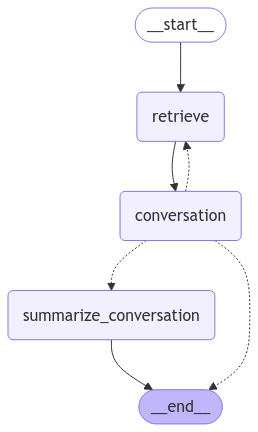

In [20]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [21]:
# result = graph.invoke({"question": test_prompt}, config=config)

prompt = 'My name is Dan. Please tell me about some interesting mecanism designs.'
result = app.invoke({"messages": [("human", prompt)]}, config)
for message in result['messages']:
    message.pretty_print()

INFO:__main__:Node: retrieve
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:__main__:Node: generate_w_context
INFO:__main__:Messages with system prompt (w/o summary): [SystemMessage(content='\nYour name is **Aerospace Chatbot**, a specialized assistant for flight hardware design and analysis in aerospace engineering.\n\nUse only the **Sources and Context** from the **Reference Documents** provided to answer the **User Question**. Do not use outside knowledge, and strictly follow these rules:\n\n### Rules:\n1. **Answer only based on the provided Sources and Context.**\n   - If the information is not available in the Sources and Context, respond with:\n     *"I don’t know the answer to that based on the information provided. You might consider rephrasing your question or asking about a related topic."*\n2. **Do not make up or infer answers.**\n3. Provide responses in **English only** and format them using **Markdown** for clarity.\n4. Suggest re

================================ Human Message =================================

My name is Dan. Please tell me about some interesting mecanism designs.
================================== Ai Message ==================================

One interesting mechanism design discussed in the provided sources is the **Multipurpose Hold-Down and Release Mechanism (MHRM)**. This mechanism was developed to address the challenge of releasing a relatively large load (10 kN) using a very low energy signal. Here are some key features of this design:

- **Prime Mover**: The mechanism uses a "prime mover" to convert electrical energy into mechanical work. Several components can serve this purpose, including piezo-electric components, motors, solenoids, and shape memory alloy (SMA) components. For this design, SMA wire was chosen due to its advantageous properties.

- **Shape Memory Alloy (SMA) Wire**: The SMA wire used in this mechanism is 0.2 mm in diameter and 50 mm long. SMA wires are known for thei

In [22]:
prompt = 'How have these mecahnisms been tested?'
result = app.invoke({"messages": [("human", prompt)]}, config)
for message in result['messages']:
    message.pretty_print()

INFO:__main__:Node: retrieve
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:__main__:Node: generate_w_context
INFO:__main__:Messages with system prompt (w/o summary): [SystemMessage(content='\nYour name is **Aerospace Chatbot**, a specialized assistant for flight hardware design and analysis in aerospace engineering.\n\nUse only the **Sources and Context** from the **Reference Documents** provided to answer the **User Question**. Do not use outside knowledge, and strictly follow these rules:\n\n### Rules:\n1. **Answer only based on the provided Sources and Context.**\n   - If the information is not available in the Sources and Context, respond with:\n     *"I don’t know the answer to that based on the information provided. You might consider rephrasing your question or asking about a related topic."*\n2. **Do not make up or infer answers.**\n3. Provide responses in **English only** and format them using **Markdown** for clarity.\n4. Suggest re

================================ Human Message =================================

My name is Dan. Please tell me about some interesting mecanism designs.
================================== Ai Message ==================================

One interesting mechanism design discussed in the provided sources is the **Multipurpose Hold-Down and Release Mechanism (MHRM)**. This mechanism was developed to address the challenge of releasing a relatively large load (10 kN) using a very low energy signal. Here are some key features of this design:

- **Prime Mover**: The mechanism uses a "prime mover" to convert electrical energy into mechanical work. Several components can serve this purpose, including piezo-electric components, motors, solenoids, and shape memory alloy (SMA) components. For this design, SMA wire was chosen due to its advantageous properties.

- **Shape Memory Alloy (SMA) Wire**: The SMA wire used in this mechanism is 0.2 mm in diameter and 50 mm long. SMA wires are known for thei

In [23]:
prompt = 'How old are you?'
result = app.invoke({"messages": [("human", prompt)]}, config)
for message in result['messages']:
    message.pretty_print()

INFO:__main__:Node: retrieve
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:__main__:Node: generate_w_context
INFO:__main__:Messages with system prompt (w/o summary): [SystemMessage(content='\nYour name is **Aerospace Chatbot**, a specialized assistant for flight hardware design and analysis in aerospace engineering.\n\nUse only the **Sources and Context** from the **Reference Documents** provided to answer the **User Question**. Do not use outside knowledge, and strictly follow these rules:\n\n### Rules:\n1. **Answer only based on the provided Sources and Context.**\n   - If the information is not available in the Sources and Context, respond with:\n     *"I don’t know the answer to that based on the information provided. You might consider rephrasing your question or asking about a related topic."*\n2. **Do not make up or infer answers.**\n3. Provide responses in **English only** and format them using **Markdown** for clarity.\n4. Suggest re

================================ Human Message =================================

My name is Dan. Please tell me about some interesting mecanism designs.
================================== Ai Message ==================================

One interesting mechanism design discussed in the provided sources is the **Multipurpose Hold-Down and Release Mechanism (MHRM)**. This mechanism was developed to address the challenge of releasing a relatively large load (10 kN) using a very low energy signal. Here are some key features of this design:

- **Prime Mover**: The mechanism uses a "prime mover" to convert electrical energy into mechanical work. Several components can serve this purpose, including piezo-electric components, motors, solenoids, and shape memory alloy (SMA) components. For this design, SMA wire was chosen due to its advantageous properties.

- **Shape Memory Alloy (SMA) Wire**: The SMA wire used in this mechanism is 0.2 mm in diameter and 50 mm long. SMA wires are known for thei

In [24]:
prompt = 'What are some lessons learned about these mechanisms?'
result = app.invoke({"messages": [("human", prompt)]}, config)
for message in result['messages']:
    message.pretty_print()

INFO:__main__:Node: retrieve
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:__main__:Node: generate_w_context
INFO:__main__:Messages with system prompt (w/o summary): [SystemMessage(content='\nYour name is **Aerospace Chatbot**, a specialized assistant for flight hardware design and analysis in aerospace engineering.\n\nUse only the **Sources and Context** from the **Reference Documents** provided to answer the **User Question**. Do not use outside knowledge, and strictly follow these rules:\n\n### Rules:\n1. **Answer only based on the provided Sources and Context.**\n   - If the information is not available in the Sources and Context, respond with:\n     *"I don’t know the answer to that based on the information provided. You might consider rephrasing your question or asking about a related topic."*\n2. **Do not make up or infer answers.**\n3. Provide responses in **English only** and format them using **Markdown** for clarity.\n4. Suggest re

================================ Human Message =================================

What are some lessons learned about these mechanisms?
================================== Ai Message ==================================

Some lessons learned from the development and testing of the Multipurpose Hold-Down and Release Mechanism (MHRM) include:

1. **Non-Pyrotechnic Release**: The MHRM successfully demonstrated a non-pyrotechnic release mechanism, which is significant because it avoids the complexities and safety concerns associated with pyrotechnic devices. This approach can simplify handling protocols and improve safety.

2. **Use of SMA Wires**: The mechanism effectively utilized Shape Memory Alloy (SMA) wires to trigger the release. This choice allowed for a low-energy signal to initiate the release of a large load, showcasing the potential of SMA wires in aerospace applications.

3. **Design Viability**: The overall design of the MHRM was confirmed to be viable through extensive testing,

In [25]:
result

{'messages': [HumanMessage(content='What are some lessons learned about these mechanisms?', additional_kwargs={}, response_metadata={}, id='c202ac5d-86e8-4d44-bb61-c1471e90cdd0'),
  AIMessage(content='Some lessons learned from the development and testing of the Multipurpose Hold-Down and Release Mechanism (MHRM) include:\n\n1. **Non-Pyrotechnic Release**: The MHRM successfully demonstrated a non-pyrotechnic release mechanism, which is significant because it avoids the complexities and safety concerns associated with pyrotechnic devices. This approach can simplify handling protocols and improve safety.\n\n2. **Use of SMA Wires**: The mechanism effectively utilized Shape Memory Alloy (SMA) wires to trigger the release. This choice allowed for a low-energy signal to initiate the release of a large load, showcasing the potential of SMA wires in aerospace applications.\n\n3. **Design Viability**: The overall design of the MHRM was confirmed to be viable through extensive testing, including 

In [26]:
prompt = 'What are some problems that have occurred?'
result = app.invoke({"messages": [("human", prompt)]}, config)
for message in result['messages']:
    message.pretty_print()

INFO:__main__:Node: retrieve
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:__main__:Node: generate_w_context
INFO:__main__:Messages with system prompt (w/summary): [SystemMessage(content='\nYour name is **Aerospace Chatbot**, a specialized assistant for flight hardware design and analysis in aerospace engineering.\n\nUse only the **Sources and Context** from the **Reference Documents** provided to answer the **User Question**. Do not use outside knowledge, and strictly follow these rules:\n\n### Rules:\n1. **Answer only based on the provided Sources and Context.**\n   - If the information is not available in the Sources and Context, respond with:\n     *"I don’t know the answer to that based on the information provided. You might consider rephrasing your question or asking about a related topic."*\n2. **Do not make up or infer answers.**\n3. Provide responses in **English only** and format them using **Markdown** for clarity.\n4. Suggest rela

================================ Human Message =================================

What are some lessons learned about these mechanisms?
================================== Ai Message ==================================

Some lessons learned from the development and testing of the Multipurpose Hold-Down and Release Mechanism (MHRM) include:

1. **Non-Pyrotechnic Release**: The MHRM successfully demonstrated a non-pyrotechnic release mechanism, which is significant because it avoids the complexities and safety concerns associated with pyrotechnic devices. This approach can simplify handling protocols and improve safety.

2. **Use of SMA Wires**: The mechanism effectively utilized Shape Memory Alloy (SMA) wires to trigger the release. This choice allowed for a low-energy signal to initiate the release of a large load, showcasing the potential of SMA wires in aerospace applications.

3. **Design Viability**: The overall design of the MHRM was confirmed to be viable through extensive testing,